In [4]:
import pandas as pd
import nasdaqdatalink
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [5]:
from lib.nasdaq import Fundamentals, Tickers, Nasdaq
from lib.equity.fundamentals import peer_percentiles

from lib.calendar import Calendar
cal = Calendar()

In [6]:
pd.options.display.float_format = '{:,.4f}'.format

In [7]:
ticker = 'GOOGL'

In [8]:
Nasdaq().authenticate()

In [9]:
def calculate_fundamentals(df):
    df['total_expense'] = df['revenue'] - df['netinc']
    df['pbt'] = df['revenue'] - df['total_expense'] + df['taxexp']  # profit before tax
    df['tax_rate'] = df['taxexp'] / df['pbt']
    df['nopat']  = df['opinc'] * (1-df['tax_rate'])
    df['payout_ratio'] = df['dps'] / df['eps']

    return df
    

In [173]:
income_statement_fields = ['revenue', 'cor', 'intexp','depamor','ebt', 'taxexp',  'nopat', 'ncfdiv', 'retearn', 'rnd', 'sgna', 'opex']

In [174]:
balance_sheet_fields = ['cashneq', 'assetsc', 'ppnenet', 'liabilitiesc', 'debt', 'marketcap']

## Selected Fundamentals

In [267]:
history = nasdaqdatalink.get_table('SHARADAR/SF1', dimension="MRQ", ticker = ticker,  paginate=True) 
history = calculate_fundamentals(history)
history = history.iloc[:5]

In [268]:
date_columns = [x.date() for x in history.calendardate]
date_columns

[datetime.date(2022, 6, 30),
 datetime.date(2022, 3, 31),
 datetime.date(2021, 12, 31),
 datetime.date(2021, 9, 30),
 datetime.date(2021, 6, 30)]

In [269]:
t_columns = [f'T{n+1-len(date_columns)}' for n in range(len(date_columns))]
t_columns

['T-4', 'T-3', 'T-2', 'T-1', 'T0']

Historical fundamentals as reported 

In [270]:
history = history.reindex(index=history.index[::-1]) # reorder index to put most recent row last
history.iloc[:, 6:] = history.iloc[:, 6:].apply(lambda x : x.astype(float)) # skip date columns

In [271]:
history = history[ ['calendardate'] + income_statement_fields + balance_sheet_fields].set_index('calendardate').T
history.style.bar(axis=1, color = 'lightgreen', width = 100, height = 80, align = 'left').format('${0:,.0f}')

calendardate,2021-06-30 00:00:00,2021-09-30 00:00:00,2021-12-31 00:00:00,2022-03-31 00:00:00,2022-06-30 00:00:00
revenue,"$61,880,000,000","$65,118,000,000","$75,325,000,000","$68,011,000,000","$69,685,000,000"
cor,"$26,227,000,000","$27,621,000,000","$32,988,000,000","$29,599,000,000","$30,104,000,000"
intexp,"$76,000,000","$77,000,000","$117,000,000","$83,000,000","$83,000,000"
depamor,"$2,945,000,000","$3,304,000,000","$3,439,000,000","$3,782,000,000","$3,899,000,000"
ebt,"$21,985,000,000","$23,064,000,000","$24,402,000,000","$18,934,000,000","$19,014,000,000"
taxexp,"$3,460,000,000","$4,128,000,000","$3,760,000,000","$2,498,000,000","$3,012,000,000"
nopat,"$16,313,965,204","$17,266,866,805","$18,512,833,784","$17,442,958,910","$16,371,458,189"
ncfdiv,$0,$0,$0,$0,$0
retearn,"$176,939,000,000","$183,782,000,000","$191,484,000,000","$195,221,000,000","$196,845,000,000"
rnd,"$7,675,000,000","$7,694,000,000","$8,708,000,000","$9,119,000,000","$9,841,000,000"


In [281]:
history.columns = t_columns
# history

Percent change

In [282]:
assumptions = history.pct_change(axis=1).dropna(how = 'all', axis=1)
assumptions['mean'] = assumptions.mean(axis=1)
assumptions.style.bar(axis=1, color = ['red', 'lightgreen'],  height = 80, align = 'mid',
                subset = t_columns[1:])#.format('{:.2f}%')

,T-3,T-2,T-1,T0,mean
revenue,0.052327,0.156746,-0.097099,0.024614,0.034147
cor,0.053151,0.194309,-0.102734,0.017061,0.040447
intexp,0.013158,0.519481,-0.290598,0.000000,0.060510
depamor,0.121902,0.040860,0.099738,0.030936,0.073359
ebt,0.049079,0.058012,-0.224080,0.004225,-0.028191
taxexp,0.193064,-0.089147,-0.335638,0.205765,-0.006489
nopat,0.058410,0.072159,-0.057791,-0.061429,0.002837
ncfdiv,nan,nan,nan,nan,nan
retearn,0.038674,0.041908,0.019516,0.008319,0.027104
rnd,0.002476,0.131791,0.047198,0.079175,0.065160


Factors used to forecast future periods via matrix multiplication

In [ ]:
# model = pd.DataFrame()

# model['revenue'] = mr.revenue * (1 + assumptions['mean'].loc['revenue_growth'])
# model['cor'] = model['revenue'] * assumptions['mean'].loc['cogs_pct_of_sales']
# model['intexp'] = assumptions['mean'].loc['interest_on_debt'] * assumptions['mean'].loc['debt']
# model['depamor'] = (1 + assumptions['mean'].loc['depreciation_rate']) * assumptions['mean'].loc['depamor']
# model['ebt'] = model.revenue - model.cor - model.intexp - model.depamor -  assumptions['mean'].loc['rnd'] -  assumptions['mean'].loc['sgna']
# model['taxexp'] = mr.ebt * + assumptions['mean'].loc['tax_rate']
# model['nopat'] = model.ebt - model.taxexp
# model['ncfdiv'] = assumptions['mean'].loc['ncfdiv'] * assumptions['mean'].loc['dividend_payout_ratio']
# model['retearn'] = model.nopat - model.ncfdiv

# model.reset_index(inplace = True, drop = True)
# model['date'] = 'T+1'
# model.set_index('date', inplace = True)
# model.T

In [181]:
factors = pd.DataFrame(index = history.T.index)
factors

""
revenue
cor
intexp
depamor
ebt
taxexp
nopat
ncfdiv
retearn
rnd


## Peer Fundamentals

In [15]:
tickers = Tickers().get()

In [16]:
fundamentals = Fundamentals(calendardate=cal.previous_quarter_end())
mrq_fundamentals = tickers.merge(fundamentals.get(), how='left', on='ticker')

## Percentile Ranks

In [17]:
ticker_data = mrq_fundamentals[mrq_fundamentals.ticker == ticker]
industry = ticker_data['industry'].iloc[0]
sector = ticker_data['sector'].iloc[0]

In [18]:
sector, industry

('Technology', 'Internet Content & Information')

In [19]:
unique_sectors_list, unique_industries_list, sector_percentile_frames, sector_rank_frames , industry_percentile_frames, industry_rank_frames = peer_percentiles.fundamental_peer_percentiles()

In [20]:
box_cols = [ 'ticker','roe','roc', 'roa', 'pe','opp margin']

### Sector

In [21]:
percentiles = sector_percentile_frames.get(sector)
# percentiles[ box_cols[1:]]
percentiles

,index,accoci,assets,assetsc,assetsnc,bvps,capex,cashneq,cashnequsd,cor,...,retained earnigns,retention ratio,equity reinvested,expected netinc growth,expected roe growth,equity reinvestment rate,expected ebit growth,sector,date,uid
0,low,"-55,532,000.00","1,709,000.00","80,005.00",0.00,-12.48,"-29,900,000.00","3,213.00","3,213.00",0.00,...,"-923,435,000.00",-0.37,"-816,799,000.00",-0.05,-0.19,-0.34,-0.03,Technology,2022-06-30,Technology 2022-06-30
1,Q1,"-22,633,000.00","160,477,000.00","79,844,000.00","50,458,601.00",1.19,"-12,424,000.00","23,751,000.00","23,751,000.00","9,556,000.00",...,"-333,516,000.00",0.02,"-262,355,261.00",-0.02,-0.06,0.02,-0.01,Technology,2022-06-30,Technology 2022-06-30
2,median,"-2,224,326.00","792,723,000.00","317,175,000.00","327,427,000.00",4.10,"-2,664,000.00","99,083,000.00","99,083,000.00","40,581,000.00",...,"-71,901,000.00",0.11,"-15,501,000.00",-0.00,-0.00,0.11,-0.00,Technology,2022-06-30,Technology 2022-06-30
3,Q3,0.00,"2,568,365,000.00","1,171,522,000.00","1,353,125,000.00",10.72,"-371,000.00","362,584,000.00","362,584,000.00","173,759,629.00",...,"64,656,500.00",0.27,"112,549,000.00",0.00,0.02,0.27,0.00,Technology,2022-06-30,Technology 2022-06-30
4,high,"29,177,000.00","6,118,580,000.00","2,738,490,000.00","3,305,993,000.00",24.92,"9,999,000.00","865,597,000.00","865,597,000.00","408,626,000.00",...,"652,956,000.00",0.63,"640,248,000.00",0.03,0.14,0.63,0.02,Technology,2022-06-30,Technology 2022-06-30


In [22]:
ranks = sector_rank_frames.get(sector)
ranks = ranks.loc[ranks.ticker == ticker]
ranks[ ['ticker'] + box_cols[1:]]

,ticker,roe,roc,roa,pe,opp margin
2255,GOOGL,0.86,0.91,0.95,0.77,0.94


In [25]:
sector_raw = mrq_fundamentals[box_cols].loc[mrq_fundamentals.sector == sector].dropna()

In [26]:
this_ticker =sector_raw[box_cols].loc[sector_raw.ticker == ticker] 
this_ticker

,ticker,roe,roc,roa,pe,opp margin
2431,GOOGL,0.0626,0.0568,0.0451,19.9270,0.2800


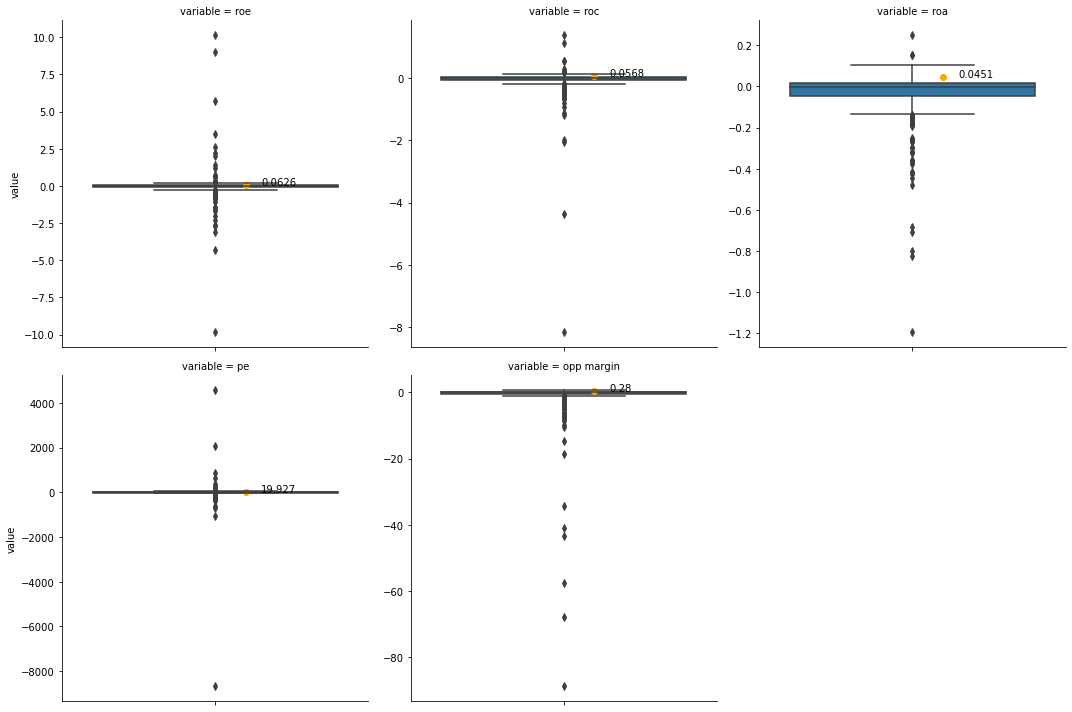

In [37]:
melt = sector_raw.melt(id_vars = 'ticker').dropna()

def annotate(data, **kws):
    n = np.round(data.value.loc[data.ticker==ticker].values[0], 4)
    ax = plt.gca()
    ax.text(.15, n, f"{n}")
    ax.scatter(.1, n, color = 'orange')
        
g = sns.FacetGrid(melt, col="variable", sharey=False,  col_wrap=3, height=5)
g.map_dataframe(sns.boxplot, y="value")
g.map_dataframe(annotate)

### Industry

In [28]:
percentiles = industry_percentile_frames.get(industry)
percentiles[ ['index'] + box_cols[1:]]

,index,roe,roc,roa,pe,opp margin
0,low,-0.26,-0.07,-0.05,-26.10,-0.39
1,Q1,-0.14,-0.04,-0.03,-20.89,-0.29
2,median,-0.03,-0.00,-0.00,-2.22,0.05
3,Q3,0.01,0.01,0.01,6.13,0.20
4,high,0.04,0.03,0.03,21.59,0.40


In [29]:
ranks = industry_rank_frames.get(industry)
ranks = ranks.loc[ranks.ticker == ticker]
ranks[ ['ticker'] + box_cols[1:]]

,ticker,roe,roc,roa,pe,opp margin
2255,GOOGL,0.78,0.93,1.00,0.89,0.96


In [32]:
industry_raw = mrq_fundamentals[box_cols].loc[mrq_fundamentals.industry == industry].dropna()

In [33]:
this_ticker =industry_raw[box_cols].loc[industry_raw.ticker == ticker] 
this_ticker

,ticker,roe,roc,roa,pe,opp margin
2431,GOOGL,0.0626,0.0568,0.0451,19.9270,0.2800


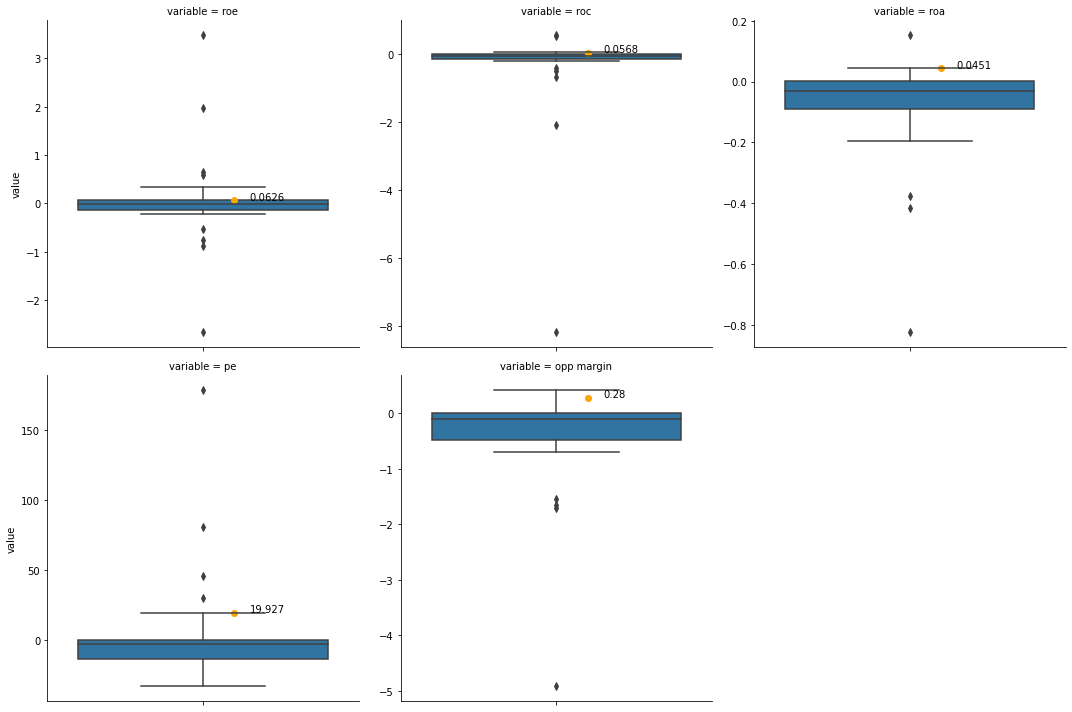

In [38]:
melt = industry_raw.melt(id_vars = 'ticker').dropna()

def annotate(data, **kws):
    n = np.round(data.value.loc[data.ticker==ticker].values[0], 4)
    ax = plt.gca()
    ax.text(.15, n, f"{n}")
    ax.scatter(.1, n, color = 'orange')
        
g = sns.FacetGrid(melt, col="variable", sharey=False,  col_wrap=3, height=5)
g.map_dataframe(sns.boxplot, y="value")
g.map_dataframe(annotate)